## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 35 columns):
DAMAGE_PROPERTY       8308 non-null float64
DURATION_SECONDS      8308 non-null float64
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
TOR_LENGTH            8308 non-null float64
TOR_WIDTH             8308 non-null float64
YEAR                  8308 non-null float64
MULTI_VORT_IND        8308 non-null int64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 1 columns):
DAMAGE_PROPERTY    8308 non-null float64
dtypes: float64(1)
memory usage: 65.0 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 2:34]

tornado_features = tornado_features.drop(["TOR_LENGTH",
                                          "TOR_WIDTH",
                                          "YEAR",
                                          "MULTI_VORT_IND",
                                          "TOR_AREA",
                                          "EXP_INC_AREA",
                                          "DAY_OF_YEAR",
                                          "MONTH"],
                                         axis = 1)


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 24 columns):
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP       8308 non-null float64
WOOD_WETLAND_PROP     8308 non-null float64
HERB_WETLAND_PROP     8308 non-null float64
INCOME                8308 non-null float64
MOB_HOME_DENS         8308 non-null float64
POP_DENS              8308 non-null float64
TOT_DEV_INT  

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
 0.5790
 0.1532
 0.2814
[torch.DoubleTensor of size 8308x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


-1.6434e+00 -4.3226e-01  1.0059e+00  ...   2.4012e-01  9.9841e-01 -8.0985e-01
 2.0633e-01  5.5447e-01  2.5095e-01  ...   6.0023e-01  2.2936e-01  5.1571e-01
-3.3130e-01 -8.9907e-01  6.5406e-01  ...  -5.8070e-01 -1.0991e+00 -1.1142e+00
                ...                   ⋱                   ...                
-2.3862e-01  6.3729e-01  2.5982e-01  ...   7.2155e-01  3.0761e-01  1.5969e-01
-1.2487e+00  6.1127e-01  1.0901e-01  ...   9.1690e-01  4.8438e-01  2.6054e-01
-4.7014e-01 -3.4764e-02  1.6123e+00  ...   5.8210e-01 -4.3274e-01 -3.8082e-01
[torch.DoubleTensor of size 8308x24]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


-1.6434e+00 -4.3226e-01  1.0059e+00  ...   2.4012e-01  9.9841e-01 -8.0985e-01
 2.0633e-01  5.5447e-01  2.5095e-01  ...   6.0023e-01  2.2936e-01  5.1571e-01
-3.3130e-01 -8.9907e-01  6.5406e-01  ...  -5.8070e-01 -1.0991e+00 -1.1142e+00
                ...                   ⋱                   ...                
-2.3862e-01  6.3729e-01  2.5982e-01  ...   7.2155e-01  3.0761e-01  1.5969e-01
-1.2487e+00  6.1127e-01  1.0901e-01  ...   9.1690e-01  4.8438e-01  2.6054e-01
-4.7014e-01 -3.4764e-02  1.6123e+00  ...   5.8210e-01 -4.3274e-01 -3.8082e-01
[torch.FloatTensor of size 8308x24]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

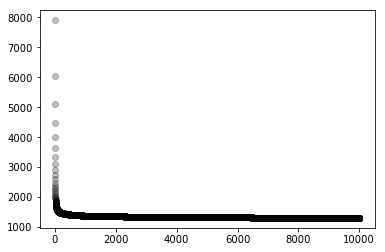

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(8308)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

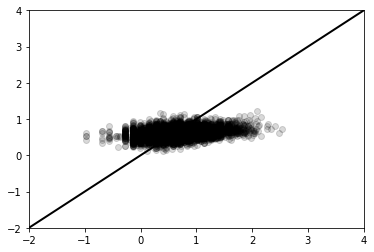

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 1 columns):
DAMAGE_PROPERTY    2808 non-null float64
dtypes: float64(1)
memory usage: 22.0 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 2:34]

valid_predictors = valid_predictors.drop(["TOR_LENGTH",
                                          "TOR_WIDTH",
                                          "YEAR",
                                          "MULTI_VORT_IND",
                                          "TOR_AREA",
                                          "EXP_INC_AREA",
                                          "DAY_OF_YEAR",
                                          "MONTH"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 24 columns):
BEGIN_LAT             2808 non-null float64
BEGIN_LON             2808 non-null float64
OPEN_WATER_PROP       2808 non-null float64
DEV_OPEN_PROP         2808 non-null float64
DEV_LOW_PROP          2808 non-null float64
DEV_MED_PROP          2808 non-null float64
DEV_HIGH_PROP         2808 non-null float64
BARREN_LAND_PROP      2808 non-null float64
DECID_FOREST_PROP     2808 non-null float64
EVERGR_FOREST_PROP    2808 non-null float64
MIXED_FOREST_PROP     2808 non-null float64
SHRUB_SCRUB_PROP      2808 non-null float64
GRASS_LAND_PROP       2808 non-null float64
PASTURE_HAY_PROP      2808 non-null float64
CULT_CROPS_PROP       2808 non-null float64
WOOD_WETLAND_PROP     2808 non-null float64
HERB_WETLAND_PROP     2808 non-null float64
INCOME                2808 non-null float64
MOB_HOME_DENS         2808 non-null float64
POP_DENS              2808 non-null float64
TOT_DEV_INT  

In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 471.1515
[torch.FloatTensor of size 1]

In [20]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(2808)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

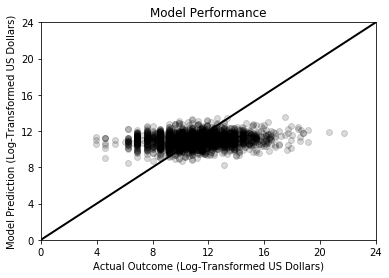

In [22]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [23]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0659 -0.2150 -0.0065 -0.0961  0.0642 -0.0249 -0.1896 -0.1516  0.0053  0.2035
 0.0968  0.1867  0.2025  0.0569  0.2026  0.0400 -0.2259 -0.1146 -0.2244 -0.0612
 0.2083  0.1352  0.0616  0.1057 -0.3577  0.2911 -0.0960  0.3560  0.1161  0.0691
 0.1788  0.0048 -0.1465  0.1629 -0.1417  0.2329 -0.1352  0.0320  0.3267  0.1857
-0.0132  0.0370 -0.0576 -0.0495  0.0010 -0.2323  0.0489  0.1104  0.0402  0.0279
-0.0888  0.1075  0.1759 -0.0033  0.0338 -0.0613  0.0135  0.0847  0.0950 -0.0511
 0.1751  0.1176 -0.1231  0.1465  0.2116  0.0174  0.1684 -0.1595  0.3230  0.2578
 0.0822  0.0124 -0.0835 -0.4211 -0.2397 -0.1262  0.2293  0.0026 -0.1180 -0.0136
 0.0676  0.1932 -0.0353 -0.2503 -0.0060 -0.2335 -0.0996  0.0752  0.0788  0.2260
 0.3852 -0.0737 -0.2392  0.1245 -0.3689  0.1157  0.1984 -0.0838 -0.3232 -0.2725
 0.0138 -0.2239 -0.1423  0.1368  0.0189 -0.0500  0.1755 -0.1625 -0.2391 -0.1046
 0.1152 -0.3087 -0.0245  0.0194 -0.1800  0.1694 -0.1174 -0.0576 -0.2471  0.1774
-

In [24]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.3847 -0.1532  0.2524 -0.3357 -0.1888 -0.3090  0.2465 -0.1970  0.2631  0.2580

Columns 10 to 15 
-0.1859 -0.3031  0.2578 -0.2120 -0.2027 -0.2080
[torch.FloatTensor of size 1x16]

## Round 2: Two-Hidden-Layer Neural Network

In [25]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [26]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 1))

In [27]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

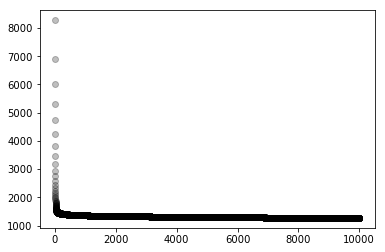

In [28]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [29]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

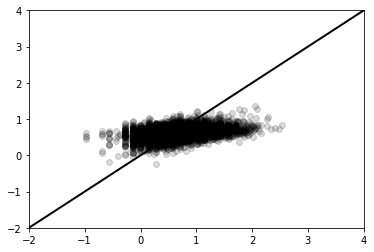

In [30]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [31]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 485.7485
[torch.FloatTensor of size 1]

In [32]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

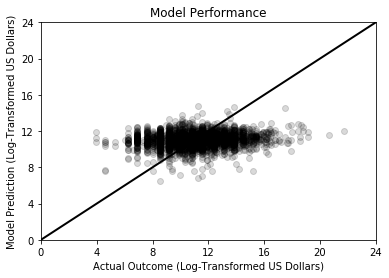

In [33]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [34]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1568 -0.1685  0.0051 -0.0116  0.1612 -0.0506 -0.3520 -0.0696  0.3183  0.0441
 0.1452  0.1289  0.1383  0.0217  0.1900 -0.0236 -0.1184  0.2204 -0.2107 -0.1516
 0.0113  0.1714  0.2292 -0.0752  0.0306  0.1986  0.0367  0.1790  0.0939 -0.4013
 0.1339  0.0902 -0.4341  0.2942  0.0069 -0.3006 -0.2218 -0.0135 -0.0509 -0.1192
 0.0243 -0.1190 -0.1778 -0.0348  0.0800 -0.1177  0.1229 -0.2047  0.5074 -0.0824
-0.2319  0.5572  0.2645 -0.0367  0.2486 -0.3638  0.0124  0.2701  0.2530 -0.1967
 0.0287  0.1427 -0.0076 -0.0667  0.0076  0.0645  0.3029 -0.1497  0.2542  0.0788
 0.1822 -0.0009 -0.0104 -0.0770 -0.0802  0.2899 -0.2451 -0.1582  0.1334  0.1116
-0.2077 -0.0335 -0.2054  0.0051 -0.0378 -0.1422 -0.2542 -0.1121 -0.1533  0.0296
 0.0565 -0.2188 -0.0985 -0.2189  0.1442  0.1591  0.2463 -0.2888  0.1659  0.0084
 0.0040  0.2239  0.2827 -0.0937 -0.3493  0.2378  0.3115  0.1316 -0.1701  0.2738
-0.0742  0.1753  0.2434 -0.1266  0.1670 -0.0420 -0.0584  0.0231  0.2147  0.1587
 

In [35]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.0619 -0.2655 -0.6715 -0.1515 -0.0727  0.2893  0.2631  0.1333  0.0024  0.1267
 0.0843  0.0318 -0.1398 -0.2499  0.1892 -0.0672  0.0981 -0.0213 -0.5219  0.1632
 0.2150 -0.3279 -0.0888 -0.3709 -0.0669  0.1653 -0.3472 -0.1207 -0.0568  0.2793
 0.2503 -0.0043  0.1185 -0.0058  0.1852 -0.2815  0.0380 -0.2010  0.0314  0.3055
-0.7061  0.3635  0.0300  0.0715 -0.9847 -0.4148  0.0603  0.7844 -1.1582  0.1176
 0.2375  0.2172  0.2798 -0.0373 -0.2562 -0.2913  0.1626 -0.2640  0.0103  0.0851
-0.4004 -0.0967 -0.0620  0.1738 -0.2976 -0.3182  0.1331 -0.2790 -0.1655 -0.5874
 0.0236 -0.1024  0.1528 -0.0773 -0.0164 -0.0583  0.1901 -0.1319 -0.0283  0.3529
 0.1336  0.1793  0.3328  0.1538  0.1685 -0.0023  0.1333 -0.3763  0.2560  0.1298
 0.0819  0.0006  0.1144  0.0549  0.2473 -0.3926  0.1970 -0.2444  0.2010  0.2442
 0.3540 -0.0623  0.3480 -0.0139 -0.0213 -0.3030  0.1308 -0.2842 -0.1189  0.3174

Columns 10 to 15 
 0.1009 -0.5103 -0.3907  0.0731  0.3215 -0.9359
 0.3055  0.249

In [36]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.6458 -0.4621 -0.5630  0.2343 -1.1750  0.3047  0.1492  0.1288  0.2873  0.1427

Columns 10 to 10 
 0.1648
[torch.FloatTensor of size 1x11]

## Round 3: Three-Hidden-Layer Neural Network

In [37]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [38]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 1))

In [39]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

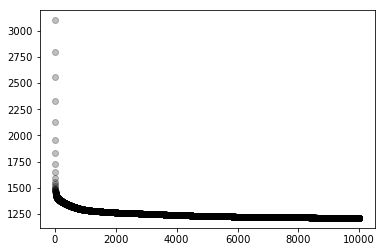

In [40]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [41]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

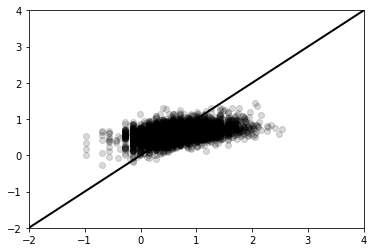

In [42]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [43]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 490.5879
[torch.FloatTensor of size 1]

In [44]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

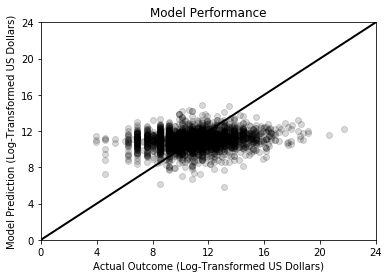

In [45]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [46]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0494 -0.1130  0.0796  0.0116  0.0913 -0.0109 -0.0961 -0.0369 -0.2410 -0.2952
-0.1623 -0.1268 -0.0124 -0.1821 -0.0317 -0.3551  0.1553 -0.1010  0.2319 -0.1183
-0.1963 -0.0186  0.0773  0.2270 -0.2050  0.2590 -0.1521 -0.0309  0.3630  0.2480
 0.2880  0.0586 -0.1213 -0.0004  0.1052  0.3700  0.0128  0.0234  0.1218 -0.0307
 0.2163  0.3572 -0.0214 -0.0016 -0.1280  0.0380 -0.0459  0.2002  0.1458 -0.1425
 0.3060  0.0647 -0.1675  0.2915  0.0970  0.2550 -0.1804 -0.2729 -0.1352 -0.2522
 0.2234 -0.1242  0.0353 -0.1335  0.3164 -0.2544 -0.1050  0.2239  0.0869 -0.0011
-0.0919 -0.3702 -0.3009 -0.1942 -0.2419  0.1283 -0.1465  0.1616 -0.1945 -0.0163
 0.0388 -0.3144  0.1150 -0.0737  0.1081 -0.2666  0.1127 -0.0956 -0.0815 -0.0308
-0.2300 -0.3677 -0.0723 -0.1851 -0.1492 -0.1426  0.3373  0.1190 -0.2731  0.2527
 0.1594  0.0406 -0.1039  0.3871 -0.3493  0.0823  0.0339  0.0703  0.0179  0.3344
 0.0051  0.1190 -0.2383  0.2615  0.2322 -0.0590  0.1483 -0.3399  0.1952  0.3651
-

In [47]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.0969 -0.0577 -0.1533  0.0047  0.1286 -0.0216  0.1340  0.2879  0.2645  0.2684
 0.2147  0.2517  0.0061  0.0939 -0.1171 -0.0575  0.2049  0.0155 -0.4457 -0.0107
 0.1967  0.0049  0.0397  0.2007  0.4646  0.4948 -0.0521  0.2753 -0.2486  0.0248
 0.0323 -0.9697  0.0597  0.0508 -1.0227 -0.0838  0.1712 -0.0118 -0.0925  0.1339
-0.3344  0.0189 -0.1179 -0.0250  0.1975 -0.0502  0.1355  0.0983 -0.0167 -0.3833
 0.1899  0.6362 -0.1567  0.3959 -0.2092 -0.1019  0.0761 -0.1889 -0.0187 -0.2389
 0.3647  0.3387 -0.3694  0.0632  0.2040 -0.3740 -0.1326 -0.3014 -0.0812  0.1856
-0.3828  0.2239  0.3521  0.1935 -0.0006  0.0184 -0.3035 -0.1884  0.4115  0.3102
-0.1578 -0.3317  0.2554 -0.0103 -0.4148  0.3533  0.1471 -0.4060 -0.0993  0.2568
 0.3553  0.3969 -0.0594  0.0102 -0.8217 -0.1970 -0.0201  0.2769  0.1761  0.0612
-0.1390  0.0820  0.0574  0.1714  0.0802 -0.0891  0.1725 -0.2206  0.2551 -0.4276

Columns 10 to 15 
 0.2600 -0.1977 -0.1279 -0.3814  0.0107  0.0630
-0.1292 -0.113

In [48]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.3037  0.3562 -0.0086  0.5092 -0.2544  0.2974 -0.1930 -0.0440  0.3932  0.2064
 0.3043  0.0515  0.2506 -0.0834 -0.3297  0.2795 -0.1450 -0.2510  0.3264 -0.0254
 0.0441  0.0560  0.1552 -0.2554  0.0473 -1.9288 -0.0417 -0.2319  0.0943 -0.1828
 0.4713 -0.5064 -0.2510 -2.0717  0.4393 -1.1171  0.6942  0.6974  0.3695 -0.5423
 0.0168 -0.2643 -0.2501  0.0619 -0.1810  0.0226 -0.2450 -0.0289 -0.2301 -0.3133
-2.3909  0.0149 -0.5228 -1.5679  0.5825 -0.5241  0.1861  0.6055  0.2740  0.2287
-0.2839 -0.2475 -0.1704  0.1713 -0.2786  0.0924 -0.0300 -0.2205 -0.2052  0.0798

Columns 10 to 10 
 0.2479
 0.1419
-0.6105
-0.0935
-0.3107
-0.7735
-0.0379
[torch.FloatTensor of size 7x11]

In [49]:
model[(6)].weight

Parameter containing:
 0.4807  0.3260 -0.2744 -1.1187 -0.1024  2.7989  0.2316
[torch.FloatTensor of size 1x7]

## Round 4: Four-Hidden-Layer Neural Network

In [50]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [51]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 1))

In [52]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

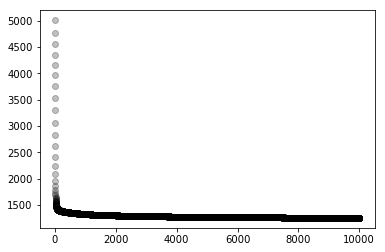

In [53]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [54]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

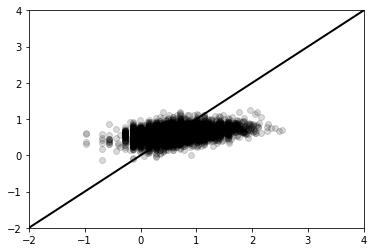

In [55]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [56]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 477.8614
[torch.FloatTensor of size 1]

In [57]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

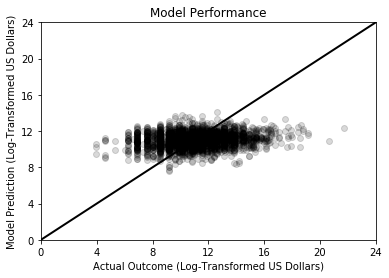

In [58]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [59]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1674  0.0083 -0.1438  0.0742 -0.0958  0.1817  0.1395 -0.0049  0.1170  0.4228
-0.4455 -0.0025 -0.1969 -0.1999  0.5725 -0.0996 -0.3211 -0.2474  0.3415 -0.0802
 0.1080  0.3100 -0.2021  0.2095  0.0524  0.1061 -0.1805  0.2920 -0.0067  0.3548
 0.1332  0.3422  0.0601  0.2119  0.1276 -0.1061 -0.1419  0.0566  0.2979  0.3090
 0.1725  0.0215 -0.1145  0.1509 -0.2145  0.1074 -0.2025 -0.2117  0.2402 -0.0329
-0.5199  0.0296  0.3319 -0.3504 -0.2381 -0.2660 -0.0149  0.0748 -0.8338 -0.0826
 0.0539  0.1562  0.1200  0.0218 -0.1253  0.4957  0.2462 -0.4606 -0.0028 -0.5861
 0.1993 -0.0075 -0.0263  0.2866  0.1960  0.2120  0.2595  0.2442  0.0256  0.2874
 0.0747  0.2699  0.2823 -0.0712  0.0834 -0.0568  0.2190  0.1048 -0.1592 -0.1074
-0.3004  0.0271  0.2147  0.1199 -0.0791 -0.1670 -0.1339  0.1673  0.0078 -0.0016
-0.0175  0.1371  0.0468  0.1868  0.1233 -0.3424 -0.1464  0.0350  0.1259 -0.0181
-0.1385 -0.1579  0.2679 -0.3444  0.1783 -0.0887 -0.1846  0.3231  0.1706  0.2938
 

In [60]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.3310 -1.3627  0.4029 -0.5850 -0.9097 -0.2711 -1.5206 -0.6195 -0.0824  0.0746
 0.3495  0.0816  0.2786 -0.3336 -0.1326 -0.1385  0.0428  0.1179  0.2530  0.2192
 0.1515 -0.0226  0.1776 -0.2410  0.3094  0.2403  0.2702 -0.0768  0.0101  0.2182
 0.2636  0.1563  0.2448 -0.1234  0.0961  0.0471  0.3446 -0.2054  0.0129  0.2780
-0.1652  0.1279  0.2282  0.2852 -0.0489  0.2845  0.3072  0.3190  0.2868  0.3844
-0.2333  0.2176  0.0253 -0.1803  0.3704  0.4084  0.4099  0.0795  0.0113  0.0074
-0.3789 -0.3614 -0.7337  0.3619  0.0269 -0.1812  0.2294 -0.0042 -0.0737 -0.1787
 0.0541  0.1220 -0.1416 -0.4264 -0.2359  0.3154  0.0856  0.0093  0.3237  0.2297
 0.0783  0.2614  0.3162 -0.2988  0.3858 -0.0229  0.0604  0.3896  0.0734  0.2736
-0.0902  0.2891 -0.0828  0.3437  0.1679  0.5748  0.1550  0.2418 -0.0367  0.2597
-0.0780  0.1730 -0.0568 -0.2910  0.3282  0.1030  0.4193 -0.1230  0.1220 -0.1257

Columns 10 to 15 
 0.2524  0.1962 -0.2101 -0.0825 -0.4529 -0.2921
 0.3570 -0.404

In [61]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-1.5444 -0.7291  0.1023 -0.2484  0.0200  0.2407  0.3896 -0.3533  0.3285 -0.0105
 0.6563  0.2016  0.3341  0.3789 -0.0590  0.4002 -0.4541  0.2626  0.3383  0.2019
-0.8686 -0.3954  0.3831  0.1358  0.0002  0.3110 -0.3694  0.3083  0.1787 -0.1806
-0.9332 -0.3041  0.3368  0.3622  0.3331  0.4301  0.0613  0.0501  0.2976  0.4394
-0.2071 -0.0593  0.0543  0.2133 -0.0920 -0.1012  0.2197 -0.2850 -0.1761 -0.2435
-0.9680 -0.1240  0.3810 -0.0808  0.3962  0.3553 -0.1253  0.1788  0.1505  0.2216
 0.5951  0.3214  0.3046  0.1191  0.0765 -0.0489 -1.0526  0.1250 -0.0178 -0.2100

Columns 10 to 10 
-0.0926
 0.2973
 0.4571
 0.1486
-0.1862
 0.2584
 0.3819
[torch.FloatTensor of size 7x11]

In [62]:
model[(6)].weight

Parameter containing:
-0.2666  0.2712 -0.0680 -0.1500 -0.1667 -0.2055 -0.2749
-0.1287 -0.1205 -0.0519  0.0749 -0.2729 -0.1208 -0.2928
 0.0703  0.1524  0.0500  0.0138 -0.2177 -0.3918 -0.0686
-0.8386  0.1749  0.2801  0.4339 -0.1781  0.4248  0.0822
 1.0284 -0.2216  0.0285  0.3214  0.1680  0.3017 -0.4763
[torch.FloatTensor of size 5x7]

In [63]:
model[(8)].weight

Parameter containing:
-0.2729  0.0083 -0.2368  0.2829 -0.8619
[torch.FloatTensor of size 1x5]

## Round 5: Five-Hidden-Layer Neural Network

In [64]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [65]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [66]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

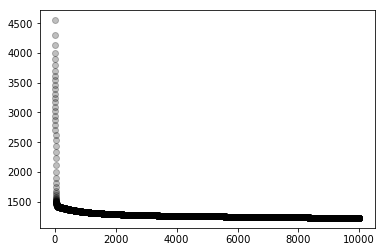

In [67]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [68]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

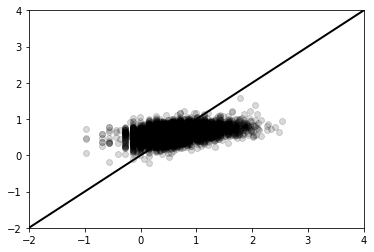

In [69]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [70]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 504.5322
[torch.FloatTensor of size 1]

In [71]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

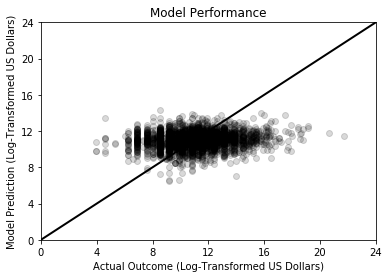

In [72]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [73]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.0862  0.1288  0.0177  0.3576  0.2123 -0.0554  0.1974 -0.0009  0.0014  0.0843
 0.0859 -0.3658 -0.1821  0.2004 -0.2586  0.2682  0.0849 -0.1516 -0.0411 -0.0072
 0.1814  0.1404 -0.1348 -0.3020 -0.2690  0.3172  0.4156 -0.0957 -0.1213 -0.5999
 0.3191  0.1436 -0.0753  0.1383  0.1393 -0.4334 -0.2562  0.5874 -0.2525  0.3931
 0.2082 -0.2282 -0.1190 -0.0730  0.0344  0.1144 -0.5804  0.0019 -0.1348  0.1081
 0.1540 -0.3818 -0.0561 -0.2492 -0.4585 -0.1098 -0.0511 -0.1544  0.3483 -0.1496
 0.1436 -0.0932  0.2547 -0.2034 -0.1622  0.2145  0.0124  0.5209  0.0268 -0.0656
 0.4305 -0.0274  0.0132 -0.2380  0.2891  0.2030  0.0718 -0.2239  0.2573  0.0858
-0.2409 -0.4885  0.0295 -0.2401  0.4123 -0.2787  0.1984  0.0316 -0.0133  0.1304
-0.1311 -0.2796  0.0268  0.1240  0.1737 -0.5227  0.0399 -0.1248 -0.0982  0.0266
 0.2140 -0.4083 -0.1937  0.1853  0.2767  0.0688  0.2249 -0.1185  0.1578  0.6823
 0.1516 -0.3434  0.2281 -0.3935  0.3039 -0.5521  0.1564  0.0335  0.4532  0.2150
-

In [74]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.1309  0.5693 -0.1697 -0.3592 -0.6983 -0.5304  0.4784 -0.1850 -0.2958 -0.2427
 0.2219  0.8740 -1.5433  0.0501 -0.1146 -0.7367 -0.3020  0.1995  0.0757 -1.7889
 0.3068  0.3880 -0.1920  0.4019 -0.2705  0.0299  0.0186  0.1535  0.3212 -0.3251
-0.1796  0.3013 -0.4959 -0.1642  0.2472  0.2581 -0.1538  0.1129 -0.1299  0.0611
-0.0677  0.1678  0.3837  0.2239  0.0506 -0.1338  0.2970 -0.0581 -0.6299  0.0466
 0.0538  0.1825  0.1531  0.4959  0.2572  0.4888 -0.0364  0.4057 -0.0047  0.3305
-0.6313 -0.0363 -0.1215  0.1999 -0.0288 -0.5056 -0.2707 -0.6627 -0.0324  0.2684
 0.1417  0.3114  0.1870  0.1578  0.2221  0.0192  0.1414  0.4702  0.3661  0.2103
 0.3380  0.2523  0.3173  0.1000  0.3403  0.3119 -0.0616  0.0009  0.2851  0.0270
 0.1791  0.6563  0.5029  0.2965 -0.0698  0.3119 -0.1255  0.3382  0.2987 -0.3821
 0.1624  0.0460 -0.1203  0.2394  0.1230  0.2459  0.2674  0.2732 -0.4783  0.2728

Columns 10 to 15 
 0.3824 -0.0420 -0.4825 -0.2944 -0.0435  0.3065
-0.6182  0.253

In [75]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
 0.1511  0.0613 -0.4766  0.4648  0.1428 -0.6038 -0.0775  0.1696  0.1879 -0.1757
-0.0175  0.1138 -0.3337  0.0117 -0.3218 -0.3175  0.0661  0.3253 -0.5624 -0.4484
 0.6520 -1.9890 -0.1573  0.6120  0.2183  0.2100  0.2936  0.3030  0.3121  0.1196
 1.1112  0.3688  0.2610  1.0095 -0.0356  0.0607  0.6986  0.4250  0.1568  0.6852
 0.4791 -0.0141 -0.7171 -0.0919 -1.0639  0.0232  0.4800  0.3799  0.0640  0.0181
 1.6209  0.0378  0.2803  1.3213 -0.0420  0.0537  1.2041  0.0128  0.2201  0.0887
 1.2028  0.4654 -0.3156  0.5336  0.0683  0.1672  0.6979 -0.3272 -0.1062  0.1738

Columns 10 to 10 
-0.0041
 0.0719
 0.2831
 0.2731
 0.2685
-0.2543
-0.2530
[torch.FloatTensor of size 7x11]

In [76]:
model[(6)].weight

Parameter containing:
 0.0390  0.0299 -0.0725 -0.1762  0.2576 -0.0615 -0.1343
-0.0236 -0.3437  0.5518  0.4577  0.3443 -0.6323 -0.0531
 2.2805  0.8122 -0.1535  0.2243 -1.1746  1.0328 -2.2274
-0.1285 -0.2378  0.1394  0.1534  0.9148 -0.7596  0.0501
 0.2189  0.2285 -0.6336  0.1843 -0.3310 -1.1747 -0.3358
[torch.FloatTensor of size 5x7]

In [77]:
model[(8)].weight

Parameter containing:
 0.0900  0.2749 -0.8970  0.2551  2.4750
 0.1500  0.2797 -0.6771  0.4263 -0.0381
 0.2703  0.1107  0.6682 -0.0125 -0.1265
[torch.FloatTensor of size 3x5]

In [78]:
model[(10)].weight

Parameter containing:
 0.5098  0.4234 -0.0577
[torch.FloatTensor of size 1x3]

## Round 6: Six-Hidden-Layer Neural Network

In [79]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [80]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [81]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

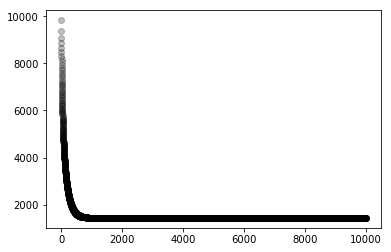

In [82]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [83]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

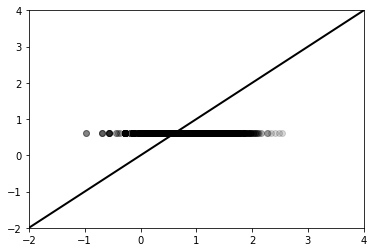

In [84]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 6.1: Validation Set Performance

In [85]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 475.4082
[torch.FloatTensor of size 1]

In [86]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

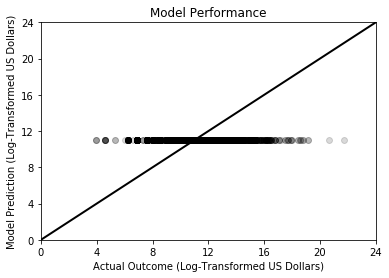

In [87]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [88]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.1688 -0.1656  0.0267 -0.1071  0.1881 -0.0612  0.0466  0.0792  0.1825 -0.1931
-0.1431  0.1706 -0.0164  0.2017  0.0193  0.1218 -0.0166 -0.0031  0.0605  0.1794
 0.1646  0.0587  0.0177  0.0311 -0.1600  0.1765 -0.1578  0.1775 -0.0683 -0.0232
 0.1311  0.1138  0.1792 -0.1019 -0.0231  0.0828  0.1704  0.0667 -0.1972  0.0205
-0.0648 -0.1651  0.0715  0.0192 -0.1910 -0.1172 -0.1744  0.0981 -0.0299  0.1740
-0.0610 -0.1220 -0.0616 -0.0155 -0.0041 -0.1621 -0.0903 -0.1454  0.0044 -0.0591
-0.1419  0.0529 -0.1913 -0.0850 -0.0179  0.0353  0.0662 -0.0443 -0.0662  0.0300
 0.1145 -0.0214  0.1566  0.0703 -0.0494  0.1308  0.1444  0.0975 -0.1230  0.1654
-0.1001  0.0767  0.0769 -0.1179  0.1387  0.0228 -0.1393  0.0717 -0.0079  0.1268
 0.1367 -0.0857  0.0888  0.0625 -0.1745 -0.0071 -0.1409  0.1110 -0.1641  0.1257
 0.0038 -0.0020 -0.0840 -0.0576  0.1156  0.1087  0.0345  0.1058  0.1032  0.0935
-0.0523 -0.1866  0.1637  0.0939  0.1312 -0.0701  0.0560  0.1362  0.1168  0.1415
 

In [89]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.0280 -0.2473 -0.0835  0.1523  0.0099 -0.1439  0.1093 -0.0780  0.1458 -0.1324
-0.0898  0.1370  0.1551 -0.1145  0.1733 -0.1562  0.2225  0.0858 -0.2344  0.1858
-0.2409 -0.0845  0.0419 -0.0723  0.1717  0.1061 -0.2109  0.1460 -0.1070  0.1991
-0.0525 -0.2302  0.0952 -0.1414 -0.2130  0.1527  0.0079  0.1512  0.2421  0.2249
 0.0578 -0.0616 -0.1457 -0.2410 -0.0439  0.0424  0.1350 -0.0819  0.1372 -0.0249
 0.0611 -0.0641  0.0741 -0.1954  0.0712 -0.0301  0.0863 -0.0433  0.1585  0.2324
 0.0553 -0.2140  0.0192  0.1551 -0.0284 -0.1310  0.2043 -0.1430 -0.1709 -0.1399
 0.0677  0.0155 -0.1529 -0.0514  0.1441  0.0510 -0.0327 -0.2305 -0.1680  0.0759
 0.0411 -0.0276  0.1775  0.1757 -0.0542  0.0978 -0.0591  0.1047 -0.1803 -0.0349
-0.0372 -0.1034 -0.1293  0.0501 -0.0541 -0.0093 -0.1735 -0.0372 -0.1398 -0.1383
 0.1535 -0.2144  0.2209  0.0088 -0.2483  0.0564 -0.0244 -0.2100 -0.1220 -0.0102

Columns 10 to 15 
-0.0927  0.0455  0.0663  0.1377  0.0930  0.0361
-0.0953  0.035

In [90]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.1266  0.1874 -0.1516  0.2823 -0.1163 -0.0085 -0.1784 -0.0814  0.0955 -0.1010
 0.1846 -0.1484 -0.2239  0.1255 -0.2237  0.2888 -0.2055 -0.2363 -0.2749 -0.0560
-0.0071 -0.1898 -0.2503 -0.0621  0.2707  0.1265 -0.1363 -0.0492  0.2095  0.0652
-0.2076  0.2791  0.2431  0.1289  0.1168 -0.0664  0.0992  0.0422 -0.0900 -0.2819
-0.2520  0.2233 -0.1866 -0.0504 -0.1781 -0.1360  0.1889 -0.2099  0.2314  0.2353
-0.0070 -0.2718 -0.1506 -0.2218  0.1881 -0.0998  0.2962  0.1525 -0.0817  0.1327
-0.1796 -0.0138  0.2342 -0.2301  0.0609  0.0704  0.0495  0.0294 -0.2035 -0.0375

Columns 10 to 10 
 0.0522
-0.0893
-0.2714
 0.0311
 0.2798
-0.1487
-0.0043
[torch.FloatTensor of size 7x11]

In [91]:
model[(6)].weight

Parameter containing:
 0.1017  0.1486  0.0201  0.3409  0.0995  0.1758 -0.0264
-0.0001  0.0451  0.0789 -0.0802 -0.2634 -0.0286  0.0229
-0.3298  0.2800  0.0120  0.2728 -0.3461  0.0828  0.3402
-0.3676 -0.2933 -0.0754 -0.3436  0.0754 -0.1886 -0.1171
 0.2568  0.0319  0.0231  0.1045 -0.1092  0.0374 -0.1519
[torch.FloatTensor of size 5x7]

In [92]:
model[(8)].weight

Parameter containing:
-0.2624 -0.0497 -0.4030  0.3130  0.2672
 0.1545 -0.2399 -0.0623 -0.1387 -0.4428
 0.0115  0.3542 -0.2880  0.0522 -0.1797
[torch.FloatTensor of size 3x5]

In [93]:
model[(10)].weight

Parameter containing:
-0.5109  0.1875 -0.2699
 0.3207 -0.3660 -0.2001
[torch.FloatTensor of size 2x3]

In [94]:
model[(12)].weight

Parameter containing:
 0.9641 -0.2514
[torch.FloatTensor of size 1x2]

## Round 7: Linear Regression

In [95]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [96]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(24, 1))

In [97]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

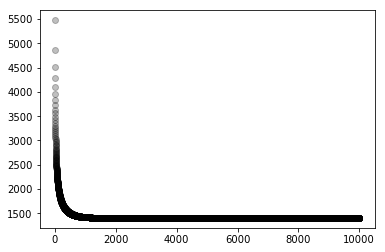

In [98]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [99]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

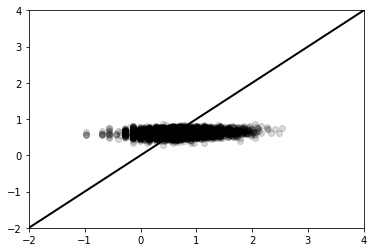

In [100]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 7.1: Validation Set Performance

In [101]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 464.4465
[torch.FloatTensor of size 1]

In [102]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

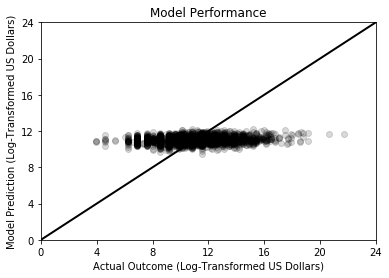

In [103]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [104]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
1.00000e-02 *
  3.0846  0.3001 -0.1348 -1.5316  1.4128 -2.7257  0.2072  0.2601  3.9447  1.3387

Columns 10 to 19 
1.00000e-02 *
 -0.0463 -1.3586  1.3119 -2.0363  0.6725  0.5755  0.6217 -0.6508  3.1973  0.3631

Columns 20 to 23 
1.00000e-02 *
  5.2769 -3.8032  2.8737 -2.0743
[torch.FloatTensor of size 1x24]